__1. Import the required libraries.__

In [1]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
from PIL import Image
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models

In [2]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
device

'cuda'

__2. Define the train and test dataset loader.__

In [3]:
# Setting up the directories to read the data
train_directory = 'root/train'
test_directory = 'root/test'

In [4]:
def loadTrainTest(train_dir, test_dir, batch_size):
    data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    }
    
    # Load train and test dataset with ImageFolder
    train_dataset = datasets.ImageFolder(root = train_dir, 
                                         transform = data_transforms['train'])
    test_dataset = datasets.ImageFolder(root = test_dir, 
                                        transform = data_transforms['test'])
    
    # Load train and test dataset into batches
    trainloader = torch.utils.data.DataLoader(dataset = train_dataset, 
                                         batch_size = batch_size,
                                         shuffle = True)
    testloader = torch.utils.data.DataLoader(dataset = test_dataset, 
                                         batch_size = batch_size,
                                         shuffle = True)
    return trainloader, testloader, train_dataset.classes


batch_size = 4
train_load, test_load, class_names = loadTrainTest(train_directory, test_directory, batch_size)

print('Classes: ', class_names) # print number of classes

Classes:  ['cat', 'dog']


__3.Show a batch of images__

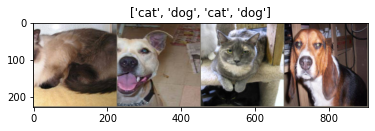

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_load))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

####  4. Finetuning 

In [6]:
model = models.vgg16(pretrained=True)

# freezing the layers
for param in model.features.parameters(): 
    param.requires_grad = False

In [7]:
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [8]:
model.classifier[6].out_features = 2

In [9]:
optimizer = optim.SGD(model.classifier.parameters(), lr=0.0001, momentum=0.5)

In [10]:
criterion = nn.CrossEntropyLoss()

In [11]:
batch_size = 4

#### 5. Train

In [13]:
def train_model(trainload, criteria, optimizer, epochs=20):
    print('\nTraining started.......\n')
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0       # Set the running loss at each epoch to zero
        for i, data in enumerate(trainload):
            inputs, labels = data  # get the inputs; data is a list of [inputs, labels]
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()  # clear the gradient
            outputs = model(inputs) # feed the input and acquire the output from network
            loss = criterion(outputs, labels) # calculating the predicted and the expected loss
            loss.backward()    # Backpropagation
            optimizer.step()    # update the parameters
            # print statistics
            running_loss += loss.item()
        print(f"ephoch {epoch + 1}, loss {loss.item():.4f}")
        print('-----------------------')
    print('\nFinished Training!')
    return model
    
    
model = train_model(train_load, criterion, optimizer, epochs=4)


Training started.......

ephoch 1, loss 0.0105
-----------------------
ephoch 2, loss 0.2052
-----------------------
ephoch 3, loss 0.0115
-----------------------
ephoch 4, loss 0.3860
-----------------------

Finished Training!


__6. Testing the model.__

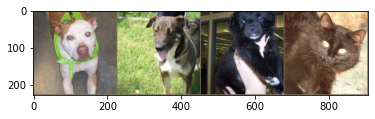

GroundTruth:    dog   dog   dog   cat


In [14]:
""" 
get some random testing images
make an iterator from test_loader
Get a batch of training images
"""
images, labels = next(iter(test_load))


# print images and labels
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % class_names[labels[j]] for j in range(batch_size)))

Predicted:    dog   dog   dog   cat


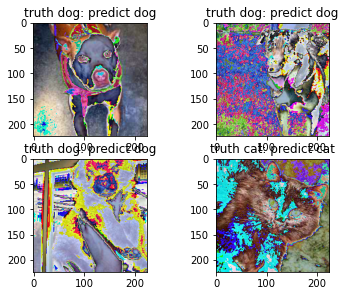

In [16]:
images = images.to(device)
results = model(images)
_, predicted = torch.max(results, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]] for j in range(batch_size)))

fig2 = plt.figure()
plt.subplots_adjust(top = 0.99)
for i in range(batch_size):
    fig2.add_subplot(2,2, i+1)
    plt.title('truth ' + class_names[labels[i]] + ': predict ' + class_names[predicted[i]])
    img = images[i] / 2 + 0.5     # this is to unnormalize the image
    img = torchvision.transforms.ToPILImage()(img)
    plt.imshow(img)
plt.show()